## A Look into King County Real Estate Market

In [1]:
#importing all relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)

from scipy import stats
import pandas as pd
import requests
from xml.etree import ElementTree
import numpy as np
import folium

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula as smf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from  matplotlib.ticker import FuncFormatter

In [2]:
#importing data set into to dfs
df = pd.read_csv('data/kc_house_data.csv')
ogdf = pd.read_csv('data/kc_house_data.csv')

### Column Names and descriptions for Kings County Data Set
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

In [3]:
#testing for multicollinearity
test = df.corr().abs().stack().reset_index().sort_values(0,ascending=False)
test['pairs'] = list(zip(test.level_0,test.level_1))
test.set_index(['pairs'], inplace=True)
test.drop(columns=['level_1','level_0'], inplace=True)
test.columns = ['cc']
test.drop_duplicates(inplace=True)

In [4]:
test.sort_values('cc',ascending=False, inplace=True)
test[test.cc >.75]

,cc
pairs,
"(id, id)",1.000000
"(sqft_living, sqft_above)",0.876448
"(grade, sqft_living)",0.762779
"(sqft_living, sqft_living15)",0.756402
"(sqft_above, grade)",0.756073
"(sqft_living, bathrooms)",0.755758


In [5]:
#dropping sqft above due to correlation with sqft living
df.drop(columns=["sqft_above"], inplace= True)

In [6]:
df.reset_index(inplace=True)

In [7]:
df.drop('index',axis=1,inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   17755 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [9]:
#looking at unique values for all columns
for col in df.columns:
    print(col)
    print(df[col].value_counts(normalize = True, ascending=False).head(5))
    print("-------------------------------------------------------------")

id
795000620     0.000139
1825069031    0.000093
2019200220    0.000093
7129304540    0.000093
1781500435    0.000093
Name: id, dtype: float64
-------------------------------------------------------------
date
6/23/2014    0.006575
6/25/2014    0.006066
6/26/2014    0.006066
7/8/2014     0.005880
4/27/2015    0.005834
Name: date, dtype: float64
-------------------------------------------------------------
price
350000.0    0.007964
450000.0    0.007964
550000.0    0.007362
500000.0    0.007038
425000.0    0.006945
Name: price, dtype: float64
-------------------------------------------------------------
bedrooms
3    0.454878
4    0.318655
2    0.127796
5    0.074131
6    0.012594
Name: bedrooms, dtype: float64
-------------------------------------------------------------
bathrooms
2.50    0.248970
1.00    0.178312
1.75    0.141131
2.25    0.094782
2.00    0.089364
Name: bathrooms, dtype: float64
-------------------------------------------------------------
sqft_living
1300    0.006390


In [10]:
#replacing ? with 0 for sqft basement
df['sqft_basement'] = df.sqft_basement.replace(to_replace= '?', value = '0')
ogdf['sqft_basement'] = ogdf.sqft_basement.replace(to_replace= '?', value = '0')

In [11]:
#converting sqft basement into int
df.sqft_basement = df.sqft_basement.map(lambda x: int(x.replace('.0','')) if type(x) != 'int' else x)
ogdf.sqft_basement = ogdf.sqft_basement.map(lambda x: int(x.replace('.0','')) if type(x) != 'int' else x)

In [12]:
#making date datetime format
df['date'] = pd.to_datetime(df['date'])

In [13]:
#adding column for month
df['month'] = df.date.dt.month

In [14]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
month               0
dtype: int64

In [15]:
#dropping na for view as only 63
df.dropna(subset=['view'],inplace=True)
ogdf.dropna(subset=['view'],inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21534 non-null  int64         
 1   date           21534 non-null  datetime64[ns]
 2   price          21534 non-null  float64       
 3   bedrooms       21534 non-null  int64         
 4   bathrooms      21534 non-null  float64       
 5   sqft_living    21534 non-null  int64         
 6   sqft_lot       21534 non-null  int64         
 7   floors         21534 non-null  float64       
 8   waterfront     19164 non-null  float64       
 9   view           21534 non-null  float64       
 10  condition      21534 non-null  int64         
 11  grade          21534 non-null  int64         
 12  sqft_basement  21534 non-null  int64         
 13  yr_built       21534 non-null  int64         
 14  yr_renovated   17704 non-null  float64       
 15  zipcode        2153

In [17]:
ogdf.fillna(0, inplace=True)

In [18]:
#getting probabilities for waterfront 1 and 0
total = 19164
no_water = len(df[df.waterfront == 0])

In [19]:
df.waterfront.value_counts(normalize=True)

0.0    0.992434
1.0    0.007566
Name: waterfront, dtype: float64

In [20]:
waterfrontweights = list(df.waterfront.value_counts(normalize=True))

In [21]:
waterfrontweights

[0.9924337299102484, 0.0075662700897516175]

In [22]:
a = [0,1]

In [23]:
#filling nan waterfront values with random probs given from our data
ogdf['waterfront'] = ogdf['waterfront'].apply(lambda x: np.random.choice(a,p=waterfrontweights) if np.isnan(x) else x)
df['waterfront'] = df['waterfront'].apply(lambda x: np.random.choice(a,p=waterfrontweights) if np.isnan(x) else x)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21534 non-null  int64         
 1   date           21534 non-null  datetime64[ns]
 2   price          21534 non-null  float64       
 3   bedrooms       21534 non-null  int64         
 4   bathrooms      21534 non-null  float64       
 5   sqft_living    21534 non-null  int64         
 6   sqft_lot       21534 non-null  int64         
 7   floors         21534 non-null  float64       
 8   waterfront     21534 non-null  float64       
 9   view           21534 non-null  float64       
 10  condition      21534 non-null  int64         
 11  grade          21534 non-null  int64         
 12  sqft_basement  21534 non-null  int64         
 13  yr_built       21534 non-null  int64         
 14  yr_renovated   17704 non-null  float64       
 15  zipcode        2153

In [25]:
#making column for age instead of yr built
df['age'] = 2020 - df['yr_built']

In [26]:
df.yr_renovated.value_counts()

0.0       16961
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [27]:
#converting yr renovated into been renovated
df['been_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x>0 else x)

In [28]:
#filling nan values with appropriate weights as given by the data
renovated_weights = list(df.been_renovated.value_counts(normalize=True))

df['been_renovated'] = df['been_renovated'].apply(lambda x: np.random.choice(a,p=renovated_weights) if np.isnan(x) else x)

In [29]:
#converting basement into binary variable
df['has_basement'] = df['sqft_basement'].map(lambda x: 1 if x >0 else x)

In [30]:
#creating column for bedrooms in to categorical grouping
#df['num_bedrooms'] = df['bedrooms'].map(lambda x: '5+' if x >= 5 else x)

In [31]:
yrrenovatedweights = list(df.yr_renovated.value_counts(normalize=True))

In [32]:
years_renindex = list(df.yr_renovated.value_counts().index)

In [33]:
#filling nan values for yr_renovated based on weights of given yrs renovated
df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.random.choice(years_renindex,p=yrrenovatedweights) if np.isnan(x) else x)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              21534 non-null  int64         
 1   date            21534 non-null  datetime64[ns]
 2   price           21534 non-null  float64       
 3   bedrooms        21534 non-null  int64         
 4   bathrooms       21534 non-null  float64       
 5   sqft_living     21534 non-null  int64         
 6   sqft_lot        21534 non-null  int64         
 7   floors          21534 non-null  float64       
 8   waterfront      21534 non-null  float64       
 9   view            21534 non-null  float64       
 10  condition       21534 non-null  int64         
 11  grade           21534 non-null  int64         
 12  sqft_basement   21534 non-null  int64         
 13  yr_built        21534 non-null  int64         
 14  yr_renovated    21534 non-null  float64       
 15  zi

In [35]:
df.been_renovated.std()

0.19927081153858206

In [36]:
df.price.mean()

540057.663833937

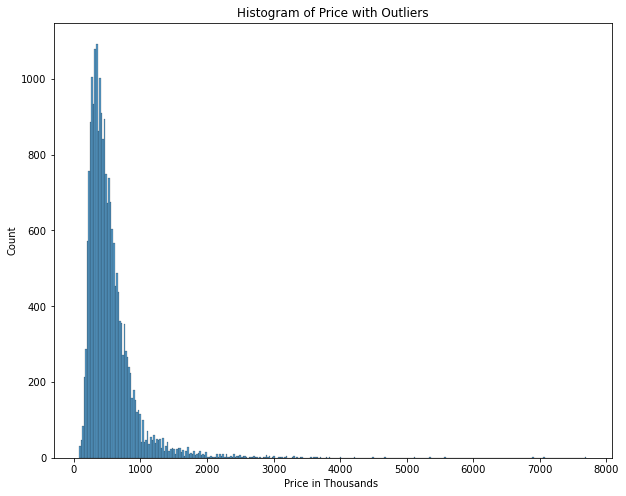

In [37]:
plt.figure(figsize=(10,8))
sns.histplot(x='price',data=df).set(xlabel='Price in Thousands ', ylabel='Count', title="Histogram of Price with Outliers")

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(round(x,0)/1000)))

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              21534 non-null  int64         
 1   date            21534 non-null  datetime64[ns]
 2   price           21534 non-null  float64       
 3   bedrooms        21534 non-null  int64         
 4   bathrooms       21534 non-null  float64       
 5   sqft_living     21534 non-null  int64         
 6   sqft_lot        21534 non-null  int64         
 7   floors          21534 non-null  float64       
 8   waterfront      21534 non-null  float64       
 9   view            21534 non-null  float64       
 10  condition       21534 non-null  int64         
 11  grade           21534 non-null  int64         
 12  sqft_basement   21534 non-null  int64         
 13  yr_built        21534 non-null  int64         
 14  yr_renovated    21534 non-null  float64       
 15  zi

## Multivariate Regression on Original Data (untransformed)

In [39]:
outcome = 'price'
x_cols = ogdf.drop(['price', 'id', 'date' ,], axis = 1).columns

x_cols

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [40]:
predictors = '+'.join(x_cols)

predictors

f = outcome + '~' + predictors 

f

ogmodel = ols(formula= f, data= ogdf).fit()
ogmodel.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     2791.
Date:                Mon, 25 Jan 2021   Prob (F-statistic):               0.00
Time:                        06:55:08   Log-Likelihood:            -2.9345e+05
No. Observations:               21534   AIC:                         5.869e+05
Df Residuals:                   21515   BIC:                         5.871e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.895e+06   2.92e+06      2.358      0.018    1.16e+06    1.26e+07
bedrooms      -3.574e+04   1896.198    -18.848      0.000   -3.95e+04    -3.2e+04
bathrooms      4.106e+04   3255.787     12.611      0.000    3.47e+04    4.74e+04
sqft_living     102.4556     18.012      5.688      0.000      67.151     137.761
sqft_lot          0.1274      0.048      2.665      0.008       0.034       0.221
floors         7068.5341   3591.513      1.968      0.049      28.903    1.41e+04
waterfront     5.955e+05   1.81e+04     32.816      0.000     5.6e+05    6.31e+05
view            5.48e+04   2118.499     25.868      0.000    5.06e+04     5.9e+04
condition      2.678e+04   2340.769     11.441      0.000    2.22e+04    3.14e+04
grade          9.683e+04   2155.795     44.914      0.000    9.26e+04    1.01e+05
sqft_above       77.9370     18.003      4.329      0.000      42.650     113.224
sqft_basement    46.4906     17.843      2.605      0.009      11.516      81.465
yr_built      -2624.5562     71.788    -36.560      0.000   -2765.266   -2483.846
yr_renovated     24.0595      3.966      6.067      0.000      16.287      31.832
zipcode        -588.0529     32.922    -17.862      0.000    -652.582    -523.524
lat             6.02e+05   1.07e+04     56.177      0.000    5.81e+05    6.23e+05
long          -2.179e+05   1.31e+04    -16.602      0.000   -2.44e+05   -1.92e+05
sqft_living15    21.3183      3.442      6.193      0.000      14.571      28.066
sqft_lot15       -0.3889      0.073     -5.318      0.000      -0.532      -0.246
==============================================================================
Omnibus:                    18187.772   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1798330.249
Skew:                           3.533   Prob(JB):                         0.00
Kurtosis:                      47.208   Cond. No.                     2.15e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Train MSE: 41021554506.39667
Test MSE: 36901585719.560455
RMSE Train: 202537.78537941177
RMSE Test: 192097.85454179454


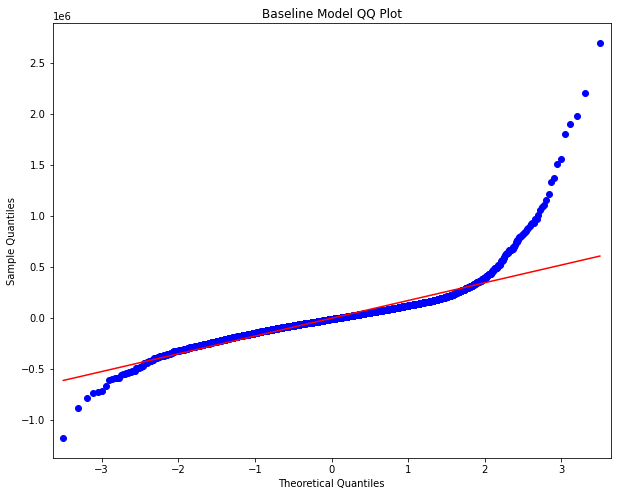

In [113]:
plt.figure(figsize=(10,8))
ax = plt.subplot(111)

data = ogdf.copy()

y = data['price']
X = data.drop(['price', 'id', 'date' ,], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

len(X_test)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)


mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat_test)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)

print('RMSE Train:', np.sqrt(mse_train))
print('RMSE Test:', np.sqrt(mse_test))

r2_score(y_test, y_hat_test)

residuals = (y_test - y_hat_test)

statsmodels.graphics.gofplots.qqplot(residuals, line = "r",ax=ax)
plt.title("Baseline Model QQ Plot")

plt.savefig('images/baselinemodelqqplot1')

As we can see above, in our original model our adjusted R^2 is .70 and all independent variables have statistically significant p-values at the .05 level. Our RMSE is 198k with a mean of 540k i.e. Our model explains 63% of the change in Y using RMSE as our metric.

In [102]:
1- (204591/ogdf.price.mean())

0.6211682312818545

## Final Model

In [44]:
#removing outliers that are 2 std away for price
df1 = df[(np.abs(stats.zscore(df['price'])) < 2)]

In [45]:
df2 = df1[(np.abs(stats.zscore(df1['bedrooms'])) < 4)]

In [46]:
df3 = df2[(np.abs(stats.zscore(df2['bathrooms'])) < 4)]

In [47]:
df4 = df3[(np.abs(stats.zscore(df3['sqft_lot15'])) < 2)]

In [48]:
fin = df4[(np.abs(stats.zscore(df4['sqft_lot'])) < 2)]

Above getting zscore outliers dropped for continuous variables. This resulted in 1673 rows being dropped

In [49]:
len(df)-len(fin)

1673

In [50]:
fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19861 entries, 0 to 21596
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              19861 non-null  int64         
 1   date            19861 non-null  datetime64[ns]
 2   price           19861 non-null  float64       
 3   bedrooms        19861 non-null  int64         
 4   bathrooms       19861 non-null  float64       
 5   sqft_living     19861 non-null  int64         
 6   sqft_lot        19861 non-null  int64         
 7   floors          19861 non-null  float64       
 8   waterfront      19861 non-null  float64       
 9   view            19861 non-null  float64       
 10  condition       19861 non-null  int64         
 11  grade           19861 non-null  int64         
 12  sqft_basement   19861 non-null  int64         
 13  yr_built        19861 non-null  int64         
 14  yr_renovated    19861 non-null  float64       
 15  zi

In [51]:
fin.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,age,been_renovated,has_basement
count,1.986100e+04,1.986100e+04,19861.000000,19861.000000,19861.000000,19861.000000,19861.000000,19861.000000,19861.000000,19861.000000,19861.000000,19861.000000,19861.000000,19861.000000,19861.000000,19861.000000,19861.000000,19861.000000,19861.000000,19861.000000,19861.000000,19861.000000,19861.000000
mean,4.686300e+09,4.838098e+05,3.327929,2.051269,1970.817935,9144.128946,1.479936,0.003373,0.177735,3.409244,7.542420,264.795126,1970.565732,74.476864,98079.713207,47.560160,-122.219375,1921.488042,8725.786718,6.579226,49.434268,0.037863,0.377574
std,2.873980e+09,2.235226e+05,0.861893,0.704757,773.099518,8008.091488,0.539514,0.057985,0.654006,0.648014,1.046153,406.471437,29.395368,378.339029,53.695094,0.138926,0.137344,624.992710,7302.644883,3.113307,29.395368,0.190870,0.484792
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,520.000000,1.000000,0.000000,0.000000,1.000000,3.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.512000,460.000000,651.000000,1.000000,5.000000,0.000000,0.000000
25%,2.215450e+09,3.150000e+05,3.000000,1.500000,1400.000000,5000.000000,1.000000,0.000000,0.000000,3.000000,7.000000,0.000000,1951.000000,0.000000,98033.000000,47.470800,-122.332000,1460.000000,5000.000000,4.000000,24.000000,0.000000,0.000000
50%,4.036400e+09,4.370000e+05,3.000000,2.000000,1850.000000,7374.000000,1.000000,0.000000,0.000000,3.000000,7.000000,0.000000,1974.000000,0.000000,98072.000000,47.570100,-122.243000,1800.000000,7457.000000,6.000000,46.000000,0.000000,0.000000
75%,7.452500e+09,6.070000e+05,4.000000,2.500000,2430.000000,9933.000000,2.000000,0.000000,0.000000,4.000000,8.000000,510.000000,1996.000000,0.000000,98118.000000,47.680100,-122.133000,2270.000000,9620.000000,9.000000,69.000000,0.000000,1.000000
max,9.900000e+09,1.270000e+06,6.000000,4.750000,7350.000000,57000.000000,3.500000,1.000000,4.000000,5.000000,12.000000,2600.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,5790.000000,65340.000000,12.000000,120.000000,1.000000,1.000000


In [52]:
fin.price.mean()

483809.7648154675

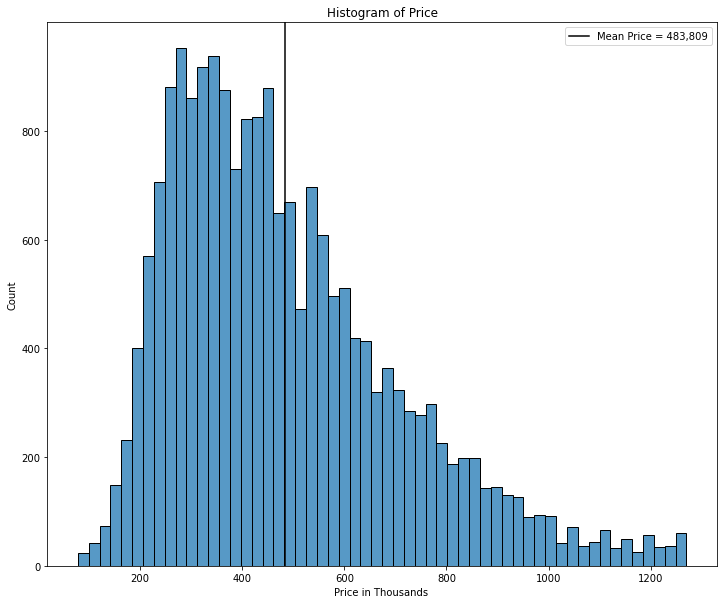

In [53]:
plt.figure(figsize=(12,10))
sns.histplot(x='price',data=fin,bins='auto' ).set(xlabel='Price in Thousands ', ylabel='Count', title="Histogram of Price")
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(round(x,0)/1000)))
plt.axvline(fin.price.mean(),c='black',label='Mean Price = 483,809')
plt.legend()
plt.savefig('images/pricehistogram')

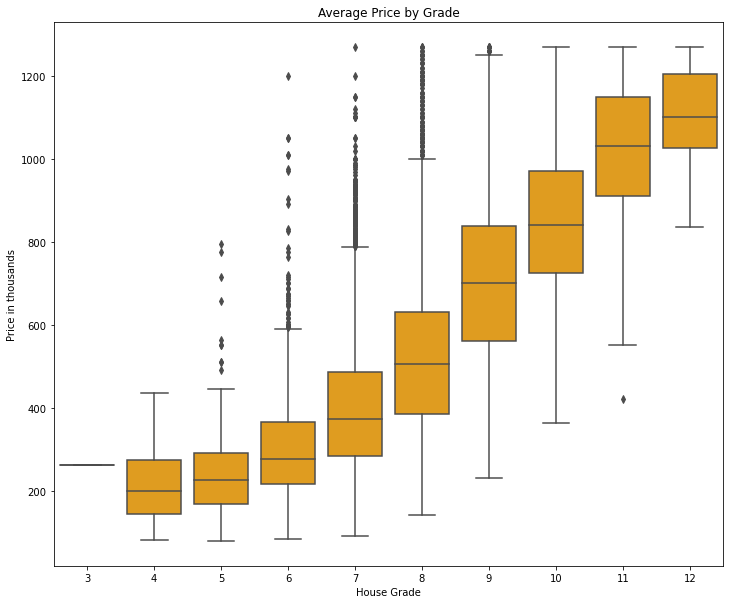

In [108]:
plt.figure(figsize=(12,10))
sns.boxplot(x='grade', y='price', data=fin,color='orange',).set(xlabel='House Grade',
                                                                ylabel='Price in thousands', title="Average Price by Grade")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(round(x,0)/1000)))
plt.savefig('images/pricevgrad2')

In [53]:
#convert bedrooms over 5 as 5+
fin['num_bedrooms'] = fin['bedrooms'].apply(lambda x: '5+' if x >= 5 else x)

<ipython-input-53-e6e2aeb4d901>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin['num_bedrooms'] = fin['bedrooms'].apply(lambda x: '5+' if x >= 5 else x)


In [57]:
fin.loc[(fin.lat > 47.5) & (fin.long > -122.05), "district"] = 'district_1'
fin.loc[(fin.lat > 47.5) & (fin.long > -122.15) & (fin.long < -122.05), "district"] = 'district_2'
fin.loc[(fin.lat > 47.5) & (fin.long > -122.259231) & (fin.long < -122.15), "district"] = 'district_3'
fin.loc[(fin.lat > 47.5) & (fin.long < -122.259231), "district"] = 'district_4'
fin.loc[(fin.lat < 47.5) & (fin.long > -122.05), "district"] = 'district_8'
fin.loc[(fin.lat < 47.5) & (fin.long > -122.15) & (fin.long < -122.05), "district"] = 'district_7'
fin.loc[(fin.lat < 47.5) & (fin.long > -122.259231) & (fin.long < -122.15), "district"] = 'district_6'
fin.loc[(fin.lat < 47.5) & (fin.long < -122.259231), "district"] = 'district_5'

C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

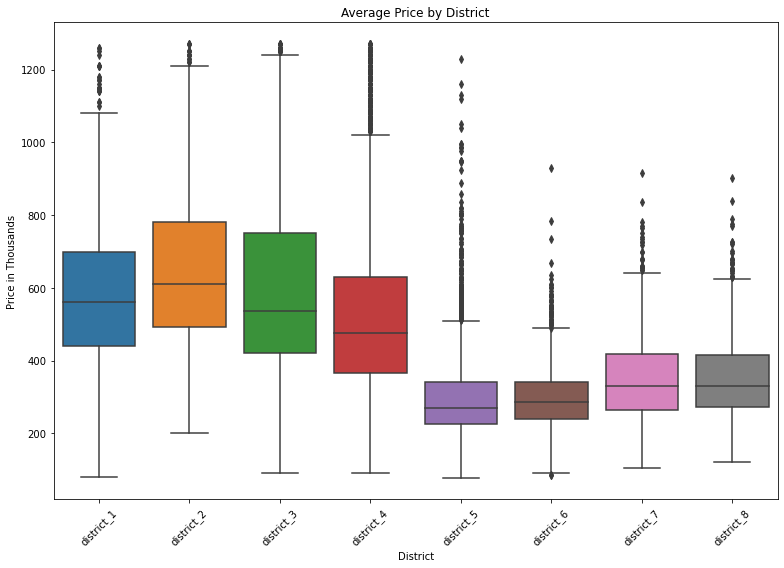

In [109]:
plt.figure(figsize=(11,8))
sns.boxplot(x='district',y='price',data=fin.sort_values('district')).set(ylabel='Price in Thousands',
                                                                         xlabel="District", title='Average Price by District')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(round(x,0)/1000)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('images/districtboxplot1')

In [59]:
view = pd.get_dummies(fin['view'], prefix='v', drop_first=True)
view.columns = view.columns.map(lambda x: x.replace('.0',''))
condition = pd.get_dummies(fin['condition'], prefix='cond', drop_first=True)
district = pd.get_dummies(fin['district'],drop_first=True)

In [60]:
final = pd.concat([fin,view,condition,district],axis=1)

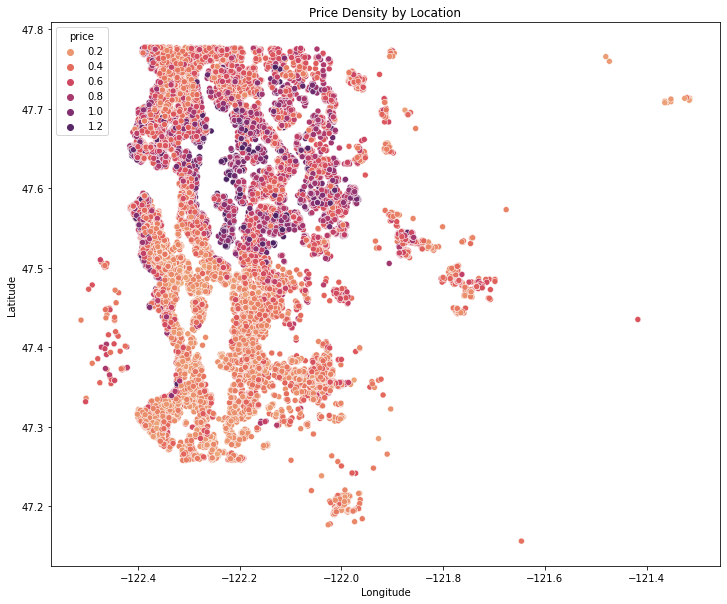

In [62]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x = "long", y = "lat", hue = 'price', data = fin,palette='flare'
               ).set(xlabel='Longitude',ylabel='Latitude', title='Price Density by Location')
plt.savefig('images/pricedensity')

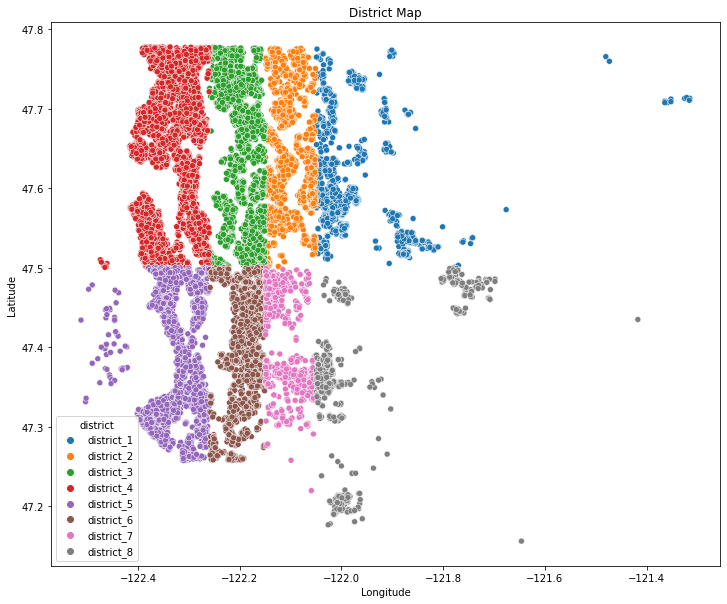

In [81]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x = "long", y = "lat", hue = 'district', data = fin.sort_values('district'),palette='tab10').set(xlabel='Longitude', ylabel='Latitude',title="District Map")
plt.savefig('images/districtmap2')

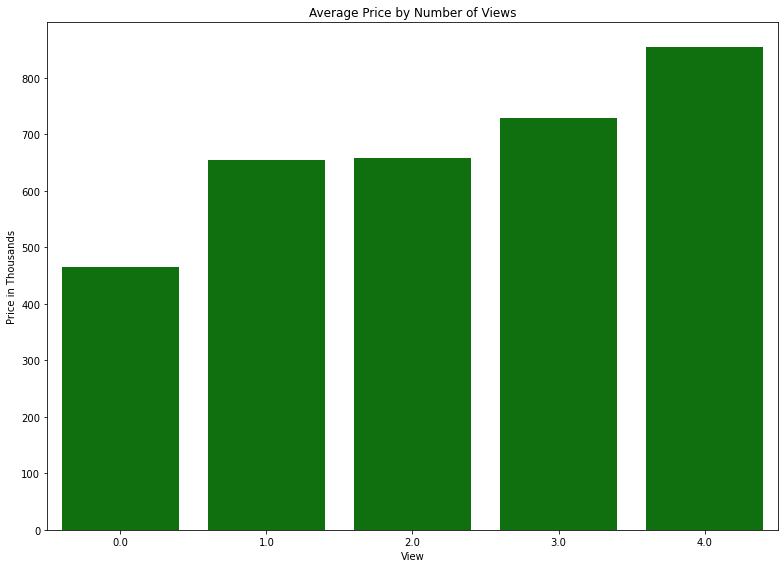

In [107]:
plt.figure(figsize=(11,8))
sns.barplot(x='view',y='price',data=fin.sort_values('view'),color='green',ci=None).set(ylabel='Price in Thousands',
                                                                         xlabel="View", title='Average Price by Number of Views')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(round(x,0)/1000)))

plt.tight_layout()
plt.savefig('images/viewbarplot1')

In [66]:
outcome = 'price'
x_cols = final.drop(['price', 'id', 'date','month','yr_built','has_basement',
                       'yr_renovated','view','condition','zipcode','lat','long','cond_2','district','sqft_lot'], axis = 1).columns

x_cols


Index(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'grade',
       'sqft_basement', 'sqft_living15', 'sqft_lot15', 'age', 'been_renovated',
       'v_1', 'v_2', 'v_3', 'v_4', 'cond_3', 'cond_4', 'cond_5', 'district_2',
       'district_3', 'district_4', 'district_5', 'district_6', 'district_7',
       'district_8'],
      dtype='object')

In [67]:
predictors = '+'.join(x_cols)

predictors

f = outcome + '~' + predictors 

f

finalmodel = ols(formula= f, data= final).fit()
finalmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     2179.
Date:                Mon, 25 Jan 2021   Prob (F-statistic):               0.00
Time:                        06:57:36   Log-Likelihood:            -2.5970e+05
No. Observations:               19861   AIC:                         5.194e+05
Df Residuals:                   19835   BIC:                         5.197e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -4.599e+05   1.31e+04    -35.153      0.000   -4.86e+05   -4.34e+05
bedrooms       -9765.5906   1258.656     -7.759      0.000   -1.22e+04   -7298.519
bathrooms       2.183e+04   2042.613     10.686      0.000    1.78e+04    2.58e+04
sqft_living       89.1472      2.491     35.782      0.000      84.264      94.031
floors          1.975e+04   2301.092      8.583      0.000    1.52e+04    2.43e+04
waterfront      1.346e+05   1.57e+04      8.554      0.000    1.04e+05    1.66e+05
grade           7.125e+04   1357.652     52.479      0.000    6.86e+04    7.39e+04
sqft_basement    -13.4052      2.844     -4.713      0.000     -18.980      -7.830
sqft_living15     49.8513      2.312     21.558      0.000      45.319      54.384
sqft_lot15        -0.5496      0.130     -4.226      0.000      -0.804      -0.295
age             1662.5772     45.513     36.530      0.000    1573.369    1751.786
been_renovated  2.883e+04   4496.244      6.413      0.000       2e+04    3.76e+04
v_1             6.186e+04   7061.713      8.760      0.000     4.8e+04    7.57e+04
v_2             5.187e+04   4340.036     11.951      0.000    4.34e+04    6.04e+04
v_3             8.196e+04   6458.191     12.691      0.000    6.93e+04    9.46e+04
v_4             1.722e+05   1.02e+04     16.931      0.000    1.52e+05    1.92e+05
cond_3          2.457e+04   8918.467      2.755      0.006    7087.315     4.2e+04
cond_4          5.225e+04   8950.979      5.838      0.000    3.47e+04    6.98e+04
cond_5          8.069e+04   9306.499      8.670      0.000    6.24e+04    9.89e+04
district_2      3.556e+04   3858.918      9.216      0.000     2.8e+04    4.31e+04
district_3      4.719e+04   3614.636     13.056      0.000    4.01e+04    5.43e+04
district_4      3.563e+04   3576.246      9.963      0.000    2.86e+04    4.26e+04
district_5     -1.623e+05   3831.046    -42.361      0.000    -1.7e+05   -1.55e+05
district_6     -1.587e+05   3845.442    -41.261      0.000   -1.66e+05   -1.51e+05
district_7      -1.44e+05   4691.342    -30.685      0.000   -1.53e+05   -1.35e+05
district_8     -1.229e+05   4763.825    -25.793      0.000   -1.32e+05   -1.14e+05
==============================================================================
Omnibus:                     2454.070   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5867.855
Skew:                           0.726   Prob(JB):                         0.00
Kurtosis:                       5.233   Cond. No.                     2.60e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.6e+05. This might indicate that there are
strong multicollinearit

Train MSE: 13500243433.76173
Test MSE: 12697173543.925148
RMSE Train: 116190.54795361683
RMSE Test: 112681.73562705336
R2 score: 0.7413


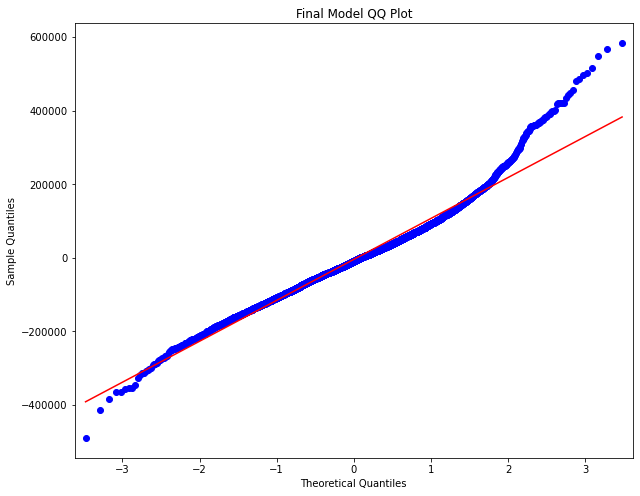

In [112]:
plt.figure(figsize=(10,8))
ax = plt.subplot(111)

data = final.copy()

y = data['price']
X = data.drop(['price', 'id', 'date','month','yr_built','has_basement',
                       'yr_renovated','view','condition','zipcode','lat','long','cond_2','district','sqft_lot'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

len(X_test)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)


mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat_test)
R2 = r2_score(y_test, y_hat_test)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)

print('RMSE Train:', np.sqrt(mse_train))
print('RMSE Test:', np.sqrt(mse_test))
print('R2 score:', round(R2,4))

residuals = (y_test - y_hat_test)

statsmodels.graphics.gofplots.qqplot(residuals, line = "r",ax=ax)
plt.title('Final Model QQ Plot')
plt.savefig('images/finalqqplot1')

In [101]:
1 - (np.sqrt(mse_test) / final.price.mean())

0.7577070621738532

Final result of the model has an R2 of .733 i.e. our model explains 73% of the variation in Y (prices). Given the dummy variables dropped, our reference model is a house with 0 views, rated 1 on condition (cond 2 was dropped due to P-value not being stat sig), and in district 1.

In [103]:
ols(formula= f, data= final).fit().params

Intercept        -459864.890320
bedrooms           -9765.590551
bathrooms          21827.676817
sqft_living           89.147181
floors             19750.435393
waterfront        134645.917740
grade              71247.987942
sqft_basement        -13.405241
sqft_living15         49.851350
sqft_lot15            -0.549567
age                 1662.577196
been_renovated     28834.769639
v_1                61863.237225
v_2                51869.067356
v_3                81958.152216
v_4               172175.806464
cond_3             24568.256074
cond_4             52251.776991
cond_5             80686.914910
district_2         35564.611207
district_3         47192.951431
district_4         35631.598359
district_5       -162286.357096
district_6       -158668.317362
district_7       -143954.797854
district_8       -122871.630741
dtype: float64

In [71]:
final.sqft_living.mean()*89

175402.79618347515

In [76]:
final.sqft_living.mean()*89

175402.79618347515

In [105]:
final.grade.mean()*71247

537374.7847540407

In [66]:
len(final[final.waterfront == 1])

69

In [67]:
len(final[(final.v_4 ==1)& (final.waterfront==1) ])

45